In [4]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [5]:
# first lets define the transformations that we need to perform on our data befor feeding it to the pipeline
# this is implemented using torchvision.transforms
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize((0.5), (0.5))])

1. ***transform.ToTensor*** - Converts the image into numbers, that are understandable by the system. It seperates the image into three color channels(separate images): r, g, b. Then it converts the pixel of each image to the brightness of their color between 0,255. These values are then scaled dowmn to a range between 0 and 1. The image is now a **Torch Tensor**.
2. ***transforms.Normalize*** - normalizes the tensor with a mean and standard deviation which goes as the two parameters respectively.

#### Download the dataset

In [6]:
trainset = datasets.MNIST("./", download=True, train=True, transform=transform)
valset = datasets.MNIST("./", download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
# batch_size the number of images we want to read in one go

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 15886746.63it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 82014687.76it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|███████████████████████████| 1648877/1648877 [00:00<00:00, 10946763.32it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 9050132.43it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



#### Knowing the dataset better

In [8]:
dataiter = iter(trainloader)
# images, labels = dataiter.next() # depricated
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


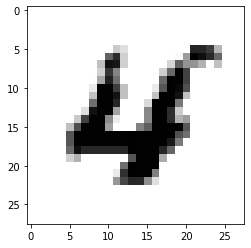

In [12]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

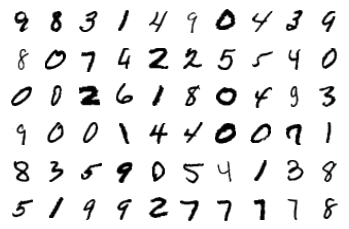

In [14]:
figure = plt.figure()
num_of_img = 60
for index in range(1, num_of_img + 1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [15]:
input_size = 784
hidden_sizes = [128,64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                     nn.ReLU(),
                     nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                     nn.ReLU(),
                     nn.Linear(hidden_sizes[1], output_size),
                     nn.LogSoftmax(dim=1))

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [16]:
# define loss criteria 
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

#### Adjusting Weights

In [17]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0032, -0.0032, -0.0032,  ..., -0.0032, -0.0032, -0.0032],
        [ 0.0033,  0.0033,  0.0033,  ...,  0.0033,  0.0033,  0.0033],
        [-0.0029, -0.0029, -0.0029,  ..., -0.0029, -0.0029, -0.0029],
        ...,
        [ 0.0028,  0.0028,  0.0028,  ...,  0.0028,  0.0028,  0.0028],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [-0.0027, -0.0027, -0.0027,  ..., -0.0027, -0.0027, -0.0027]])


#### Core training process

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector - 28*28
        images = images.view(images.shape[0], -1)
        
        # Training Pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        # This is where the model learns by backprop
        loss.backward()
        
        # And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch {e} - Training Loss: {running_loss/len(trainloader)}")
    
print("\n Training Time (in minutes) =", (time()-time0)/60)

Epoch 0 - Training Loss: 0.6496325985693348
Epoch 1 - Training Loss: 0.28577681254349285
Epoch 2 - Training Loss: 0.22284600482201145
Epoch 3 - Training Loss: 0.1803451568396615
Epoch 4 - Training Loss: 0.1507203306959096
Epoch 5 - Training Loss: 0.12964661821806386
Epoch 6 - Training Loss: 0.11206723553642853
Epoch 7 - Training Loss: 0.09909629127753378
Epoch 8 - Training Loss: 0.08811293038299312
Epoch 9 - Training Loss: 0.07882944524470868
Epoch 10 - Training Loss: 0.07247625631409318
Epoch 11 - Training Loss: 0.0655540557437217
Epoch 12 - Training Loss: 0.06076485409127322
Epoch 13 - Training Loss: 0.05605791715472174
Epoch 14 - Training Loss: 0.0512645169277179

 Training Time (in minutes) = 0.7280942877133687


#### Testing and Evaluation

Predicted Digit =  2
[4.0203352e-07, 9.136024e-05, 0.9990645, 0.0007881741, 6.8329517e-15, 3.820739e-07, 9.1353125e-10, 2.9573034e-08, 5.5150766e-05, 2.4856936e-10]


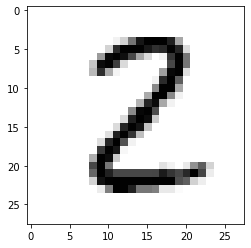

In [52]:
# model is ready, now evaluation 

images, labels = next(iter(valloader))

img = images[1].view(1,784)

# deactivate backprop for test data
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
# print(logps)
# print(ps)
print("Predicted Digit = ", probab.index(max(probab)))
print(probab)
plt.imshow(images[1].numpy().squeeze(), cmap='gray_r')

In [37]:
# iterate through the validation set
correct_count, all_count = 0,0
for images, labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)
        
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if (true_label==pred_label):
            correct_count+=1
        all_count +=1
print("Number of Images Tested = ", all_count)
print("\nModel Accuracy = ", (correct_count/all_count))

Number of Images Tested =  10000

Model Accuracy =  0.9747


#### Saving the model

In [38]:
torch.save(model, './MNIST_model.pt')